In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/creditcard.csv')


Mounted at /content/drive


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

print('Fraudulent Transactions:', len(fraud))
print('Legitimate Transactions:', len(legit))

Fraudulent Transactions: 492
Legitimate Transactions: 284315


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Import train_test_split


df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])

fraud_train, fraud_test = train_test_split(fraud, test_size=0.3, random_state=42)
legit_train, legit_test = train_test_split(legit, test_size=0.3, random_state=42)

train_data = pd.concat([fraud_train, legit_train])
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
print('Training Data Shape:', train_data.shape)

print('Fraud Data test Shape: ', fraud_test.shape)
print('Legitimate Data test Shape: ', legit_test.shape)

train_data = train_data.values
fraud_test = fraud_test.values
legit_test = legit_test.values

x_train = train_data[:, 1:30]
y_train = train_data[:, 30]


x_fraud_test = fraud_test[:, 1:30]
y_fraud_test = fraud_test[:, 30]

x_legit_test = legit_test[:, 1:30]
y_legit_test = legit_test[:, 30]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_fraud_test = scaler.transform(x_fraud_test)
x_legit_test = scaler.transform(x_legit_test)

print('X_train Shape:', x_train.shape)
print('Y_train Shape:', y_train.shape)
print('X_fraud_test Shape:', x_fraud_test.shape)
print('Y_fraud_test Shape:', y_fraud_test.shape)
print('X_legit_test Shape:', x_legit_test.shape)
print('Y_legit_test Shape:', y_legit_test.shape)

Training Data Shape: (199364, 31)
Fraud Data test Shape:  (148, 31)
Legitimate Data test Shape:  (85295, 31)
X_train Shape: (199364, 29)
Y_train Shape: (199364,)
X_fraud_test Shape: (148, 29)
Y_fraud_test Shape: (148,)
X_legit_test Shape: (85295, 29)
Y_legit_test Shape: (85295,)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

def evaluate_model(model, x_train, y_train, x_legit_test, y_legit_test, x_fraud_test, y_fraud_test):
    """
    Trains the model, evaluates individual legit & fraud accuracy,
    and returns combined confusion matrix (without redundant prediction).
    """
    # Train the model
    model.fit(x_train, y_train)

    # Predict separately
    y_pred_legit = model.predict(x_legit_test)
    y_pred_fraud = model.predict(x_fraud_test)

    # Calculate individual accuracies
    accuracy_legit = np.mean(y_pred_legit == y_legit_test)
    accuracy_fraud = np.mean(y_pred_fraud == y_fraud_test)

    # Combine predictions and labels
    y_combined_true = np.concatenate([y_legit_test, y_fraud_test])
    y_combined_pred = np.concatenate([y_pred_legit, y_pred_fraud])

    # Combined confusion matrix
    cm_combined = confusion_matrix(y_combined_true, y_combined_pred)

    return {
        "accuracy_legit": accuracy_legit,
        "accuracy_fraud": accuracy_fraud,
        "confusion_matrix_combined": cm_combined
    }


# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['Legitimate', 'Fraudulent']):
    """
    Plots a confusion matrix using seaborn heatmap.

    Args:
        cm: Confusion matrix to plot.
        title: Title of the plot.
        labels: List of class labels (default ['Legitimate', 'Fraudulent']).
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=4, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "GaussianNB": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.95895
Decision Tree Fraud Accuracy: 0.91892
Combined Confusion Matrix:


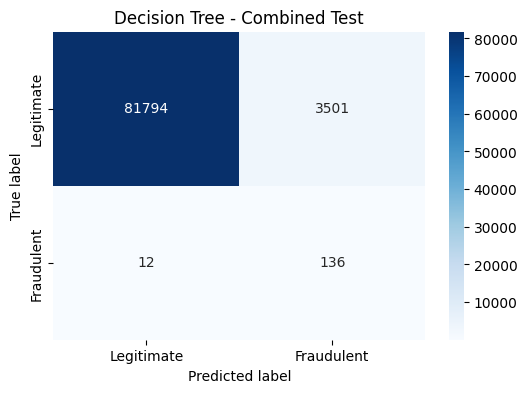

Evaluating SVM...
SVM Legit Accuracy: 0.98720
SVM Fraud Accuracy: 0.87838
Combined Confusion Matrix:


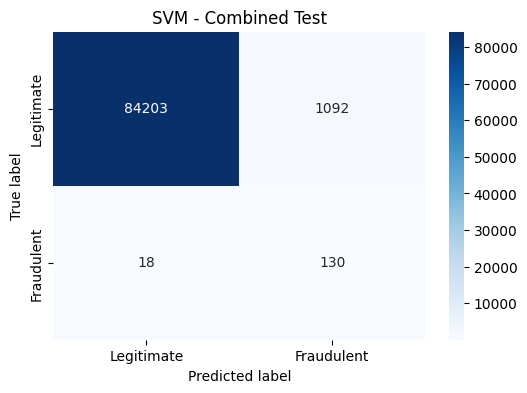

Evaluating Random Forest...
Random Forest Legit Accuracy: 0.98025
Random Forest Fraud Accuracy: 0.89865
Combined Confusion Matrix:


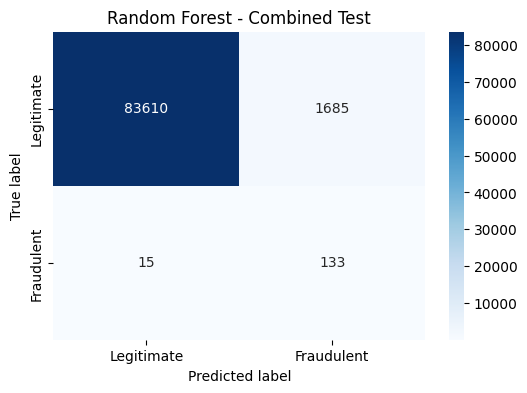

Evaluating Logistic Regression...
Logistic Regression Legit Accuracy: 0.97492
Logistic Regression Fraud Accuracy: 0.93243
Combined Confusion Matrix:


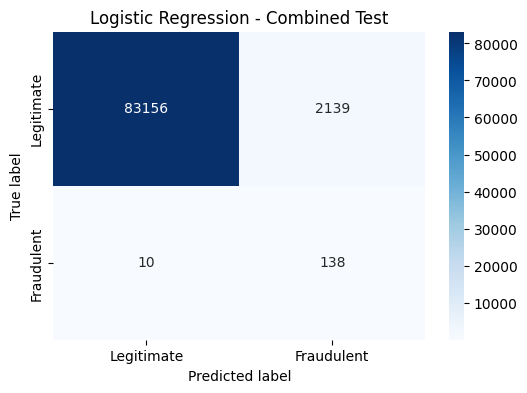

Evaluating AdaBoost...
AdaBoost Legit Accuracy: 0.95764
AdaBoost Fraud Accuracy: 0.91892
Combined Confusion Matrix:


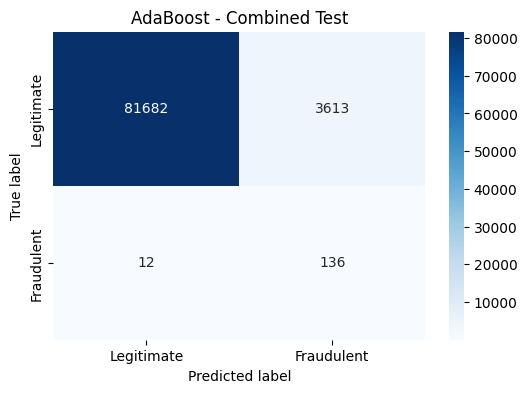

Evaluating GaussianNB...
GaussianNB Legit Accuracy: 0.97707
GaussianNB Fraud Accuracy: 0.85811
Combined Confusion Matrix:


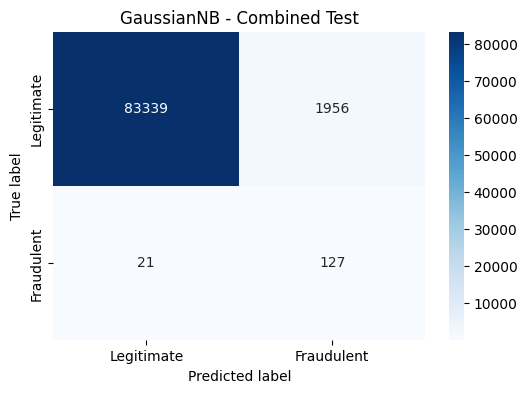

Evaluating KNN...
KNN Legit Accuracy: 0.97994
KNN Fraud Accuracy: 0.91216
Combined Confusion Matrix:


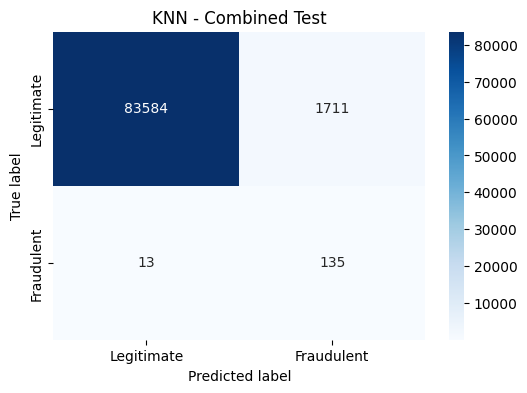

Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:10:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Legit Accuracy: 0.96863
XGBoost Fraud Accuracy: 0.91216
Combined Confusion Matrix:


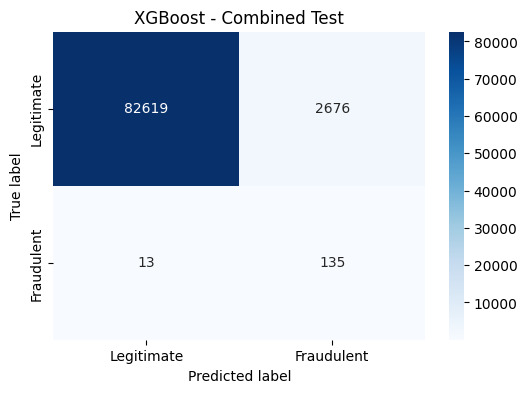

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random undersampling
rus = RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

results_rus = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Evaluate the model using the undersampled data
    results_rus[model_name] = evaluate_model(
        model, x_train_rus, y_train_rus,
        x_legit_test, y_legit_test,
        x_fraud_test, y_fraud_test
    )

    print(f"{model_name} Legit Accuracy: {results_rus[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_rus[model_name]['accuracy_fraud']:.5f}")

    # Plot combined confusion matrix
    print("Combined Confusion Matrix:")
    plot_confusion_matrix(
        results_rus[model_name]['confusion_matrix_combined'],
        title=f'{model_name} - Combined Test'
    )


In [8]:
print('shape of x_train_rus', x_train_rus.shape)
print('shape of y_train_rus', y_train_rus.shape)

print(results_rus)

shape of x_train_rus (688, 29)
shape of y_train_rus (688,)
{'Decision Tree': {'accuracy_legit': np.float64(0.9589542177149891), 'accuracy_fraud': np.float64(0.918918918918919), 'confusion_matrix_combined': array([[81794,  3501],
       [   12,   136]])}, 'SVM': {'accuracy_legit': np.float64(0.9871973738202708), 'accuracy_fraud': np.float64(0.8783783783783784), 'confusion_matrix_combined': array([[84203,  1092],
       [   18,   130]])}, 'Random Forest': {'accuracy_legit': np.float64(0.9802450319479453), 'accuracy_fraud': np.float64(0.8986486486486487), 'confusion_matrix_combined': array([[83610,  1685],
       [   15,   133]])}, 'Logistic Regression': {'accuracy_legit': np.float64(0.9749223283897063), 'accuracy_fraud': np.float64(0.9324324324324325), 'confusion_matrix_combined': array([[83156,  2139],
       [   10,   138]])}, 'AdaBoost': {'accuracy_legit': np.float64(0.9576411278504016), 'accuracy_fraud': np.float64(0.918918918918919), 'confusion_matrix_combined': array([[81682,  3613

Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.99985
Decision Tree Fraud Accuracy: 0.79054
Combined Confusion Matrix:


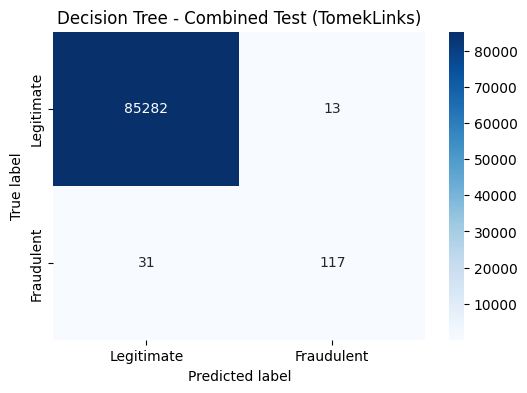

Evaluating SVM...
SVM Legit Accuracy: 0.99991
SVM Fraud Accuracy: 0.68919
Combined Confusion Matrix:


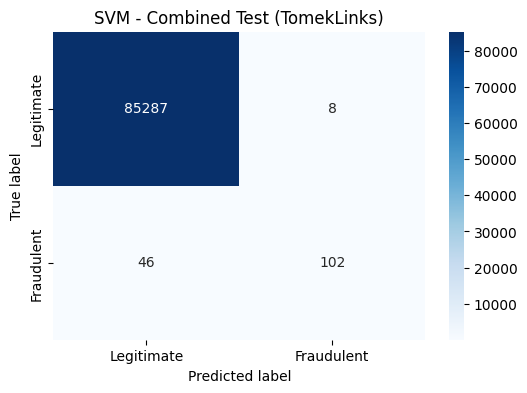

Evaluating Random Forest...
Random Forest Legit Accuracy: 0.99988
Random Forest Fraud Accuracy: 0.81081
Combined Confusion Matrix:


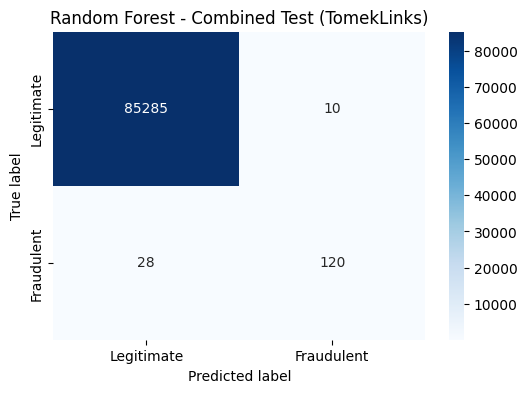

Evaluating Logistic Regression...
Logistic Regression Legit Accuracy: 0.99984
Logistic Regression Fraud Accuracy: 0.59459
Combined Confusion Matrix:


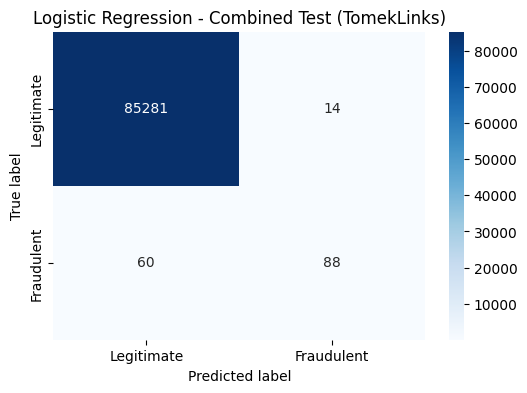

Evaluating AdaBoost...
AdaBoost Legit Accuracy: 0.99962
AdaBoost Fraud Accuracy: 0.62162
Combined Confusion Matrix:


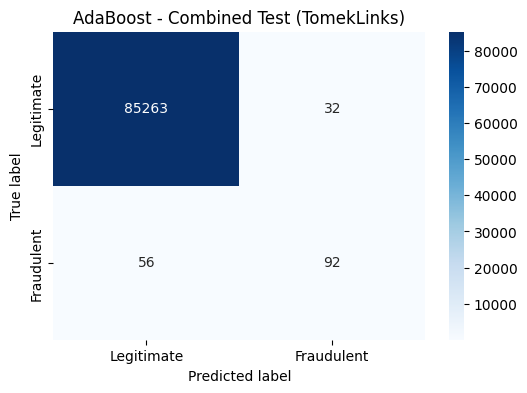

Evaluating GaussianNB...
GaussianNB Legit Accuracy: 0.97822
GaussianNB Fraud Accuracy: 0.84459
Combined Confusion Matrix:


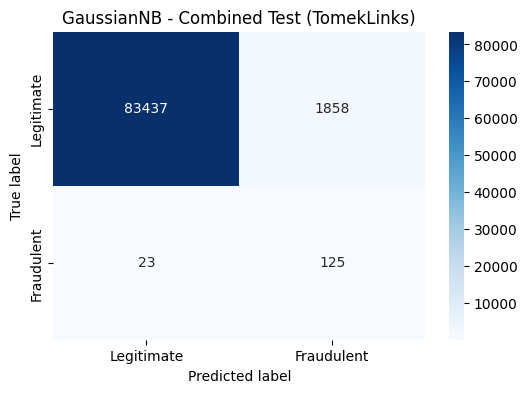

Evaluating KNN...
KNN Legit Accuracy: 0.99985
KNN Fraud Accuracy: 0.77703
Combined Confusion Matrix:


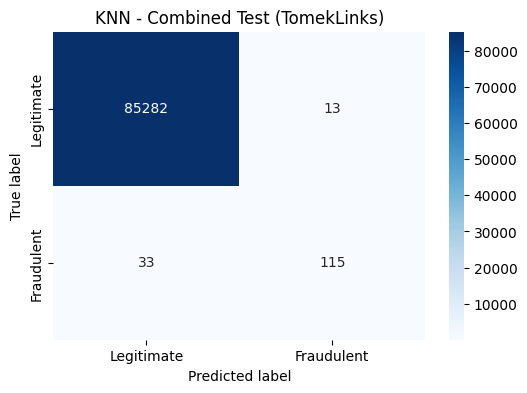

Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:23:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Legit Accuracy: 0.99991
XGBoost Fraud Accuracy: 0.79730
Combined Confusion Matrix:


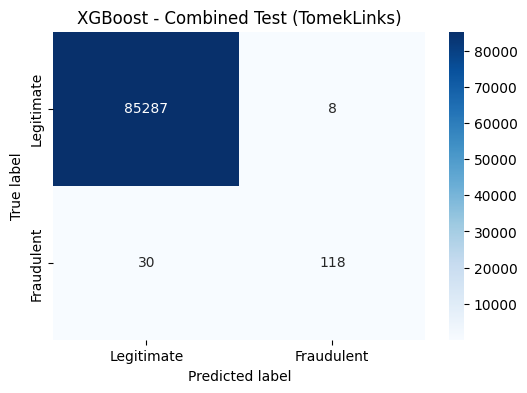

In [9]:
from imblearn.under_sampling import TomekLinks

# Apply TomekLinks undersampling
tl = TomekLinks()
x_train_tl, y_train_tl = tl.fit_resample(x_train, y_train)

results_tl = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Correctly use TomekLinks data
    results_tl[model_name] = evaluate_model(
        model, x_train_tl, y_train_tl,
        x_legit_test, y_legit_test,
        x_fraud_test, y_fraud_test
    )

    print(f"{model_name} Legit Accuracy: {results_tl[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_tl[model_name]['accuracy_fraud']:.5f}")

    # Plot combined confusion matrix
    print("Combined Confusion Matrix:")
    plot_confusion_matrix(
        results_tl[model_name]['confusion_matrix_combined'],
        title=f'{model_name} - Combined Test (TomekLinks)'
    )


In [10]:
print('shape of x_train_rus', x_train_tl.shape)
print('shape of y_train_rus', y_train_tl.shape)

print(results_tl)

shape of x_train_rus (199347, 29)
shape of y_train_rus (199347,)
{'Decision Tree': {'accuracy_legit': np.float64(0.9998475877835746), 'accuracy_fraud': np.float64(0.7905405405405406), 'confusion_matrix_combined': array([[85282,    13],
       [   31,   117]])}, 'SVM': {'accuracy_legit': np.float64(0.9999062078668152), 'accuracy_fraud': np.float64(0.6891891891891891), 'confusion_matrix_combined': array([[85287,     8],
       [   46,   102]])}, 'Random Forest': {'accuracy_legit': np.float64(0.9998827598335189), 'accuracy_fraud': np.float64(0.8108108108108109), 'confusion_matrix_combined': array([[85285,    10],
       [   28,   120]])}, 'Logistic Regression': {'accuracy_legit': np.float64(0.9998358637669266), 'accuracy_fraud': np.float64(0.5945945945945946), 'confusion_matrix_combined': array([[85281,    14],
       [   60,    88]])}, 'AdaBoost': {'accuracy_legit': np.float64(0.9996248314672607), 'accuracy_fraud': np.float64(0.6216216216216216), 'confusion_matrix_combined': array([[8526

Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.66461
Decision Tree Fraud Accuracy: 0.96622
Combined Confusion Matrix:


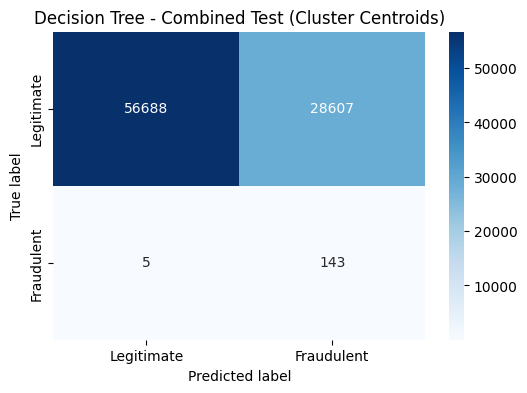

Evaluating SVM...
SVM Legit Accuracy: 0.99042
SVM Fraud Accuracy: 0.87838
Combined Confusion Matrix:


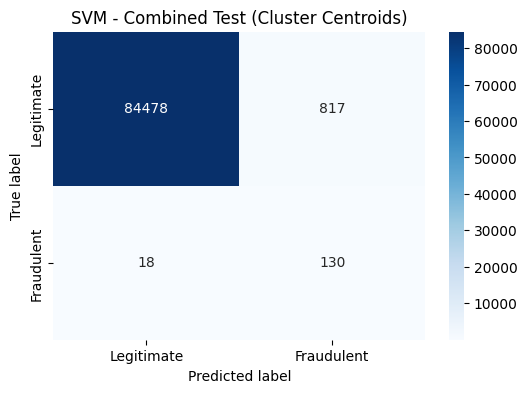

Evaluating Random Forest...
Random Forest Legit Accuracy: 0.72165
Random Forest Fraud Accuracy: 0.94595
Combined Confusion Matrix:


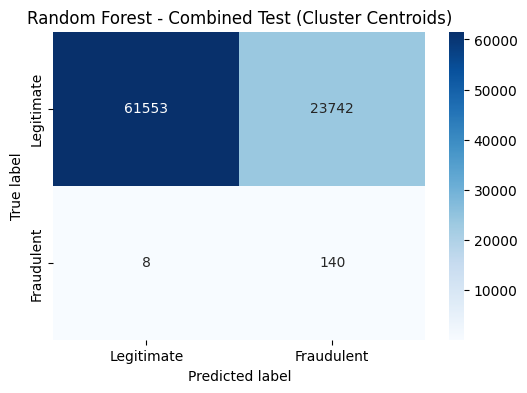

Evaluating Logistic Regression...
Logistic Regression Legit Accuracy: 0.95994
Logistic Regression Fraud Accuracy: 0.92568
Combined Confusion Matrix:


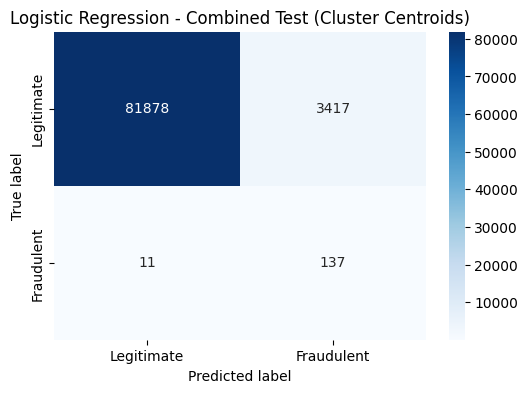

Evaluating AdaBoost...
AdaBoost Legit Accuracy: 0.71613
AdaBoost Fraud Accuracy: 0.95946
Combined Confusion Matrix:


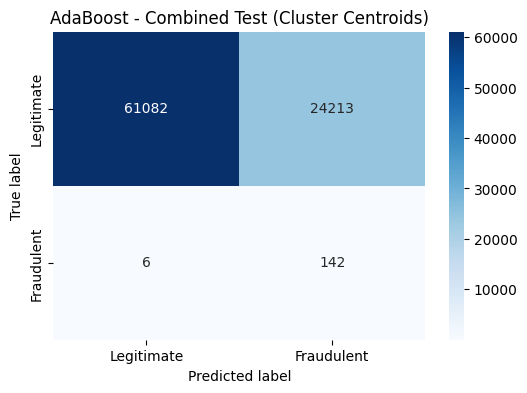

Evaluating GaussianNB...
GaussianNB Legit Accuracy: 0.99679
GaussianNB Fraud Accuracy: 0.81757
Combined Confusion Matrix:


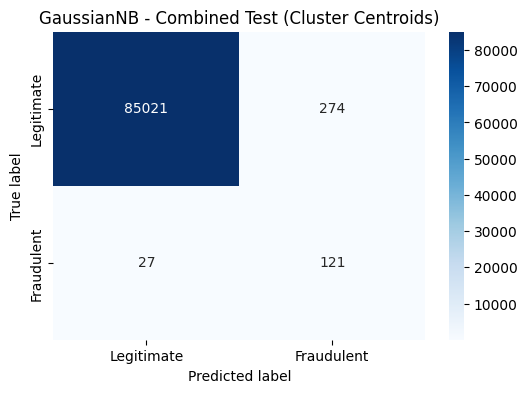

Evaluating KNN...
KNN Legit Accuracy: 0.99204
KNN Fraud Accuracy: 0.89189
Combined Confusion Matrix:


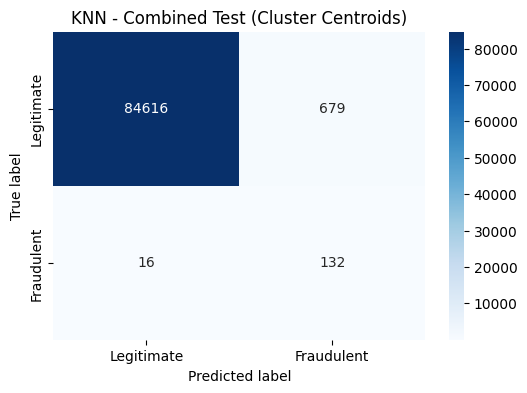

Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:24:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Legit Accuracy: 0.68617
XGBoost Fraud Accuracy: 0.97297
Combined Confusion Matrix:


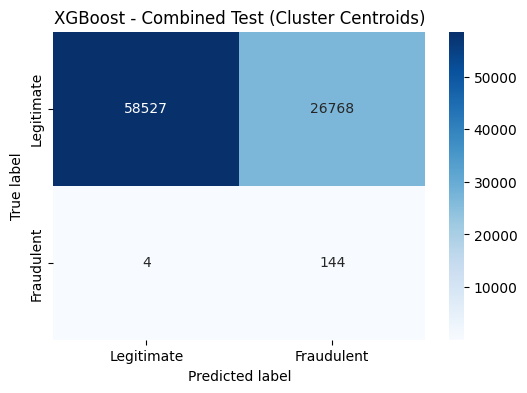

In [11]:
from imblearn.under_sampling import ClusterCentroids

# Apply Cluster Centroids undersampling
cc = ClusterCentroids(random_state=42)
x_train_cc, y_train_cc = cc.fit_resample(x_train, y_train)

results_cc = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Use correctly resampled data (Cluster Centroids)
    results_cc[model_name] = evaluate_model(
        model, x_train_cc, y_train_cc,
        x_legit_test, y_legit_test,
        x_fraud_test, y_fraud_test
    )

    print(f"{model_name} Legit Accuracy: {results_cc[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_cc[model_name]['accuracy_fraud']:.5f}")

    # Plot only the combined confusion matrix
    print("Combined Confusion Matrix:")
    plot_confusion_matrix(
        results_cc[model_name]['confusion_matrix_combined'],
        title=f'{model_name} - Combined Test (Cluster Centroids)'
    )


In [12]:
print('shape of x_train_rus', x_train_cc.shape)
print('shape of y_train_rus', y_train_cc.shape)

print(results_cc)

shape of x_train_rus (688, 29)
shape of y_train_rus (688,)
{'Decision Tree': {'accuracy_legit': np.float64(0.6646110557476992), 'accuracy_fraud': np.float64(0.9662162162162162), 'confusion_matrix_combined': array([[56688, 28607],
       [    5,   143]])}, 'SVM': {'accuracy_legit': np.float64(0.9904214783984994), 'accuracy_fraud': np.float64(0.8783783783783784), 'confusion_matrix_combined': array([[84478,   817],
       [   18,   130]])}, 'Random Forest': {'accuracy_legit': np.float64(0.7216483967407233), 'accuracy_fraud': np.float64(0.9459459459459459), 'confusion_matrix_combined': array([[61553, 23742],
       [    8,   140]])}, 'Logistic Regression': {'accuracy_legit': np.float64(0.9599390351134298), 'accuracy_fraud': np.float64(0.9256756756756757), 'confusion_matrix_combined': array([[81878,  3417],
       [   11,   137]])}, 'AdaBoost': {'accuracy_legit': np.float64(0.7161263848994666), 'accuracy_fraud': np.float64(0.9594594594594594), 'confusion_matrix_combined': array([[61082, 242

Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.99975
Decision Tree Fraud Accuracy: 0.79054
Combined Confusion Matrix:


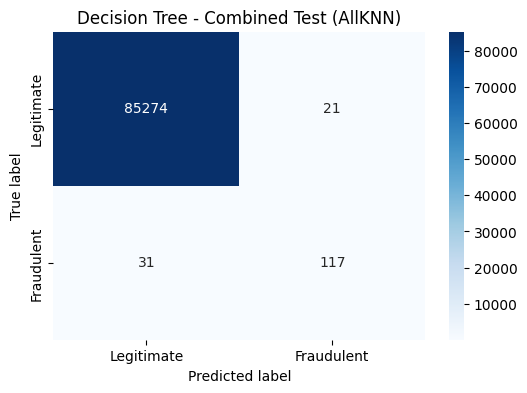

Evaluating SVM...
SVM Legit Accuracy: 0.99986
SVM Fraud Accuracy: 0.72297
Combined Confusion Matrix:


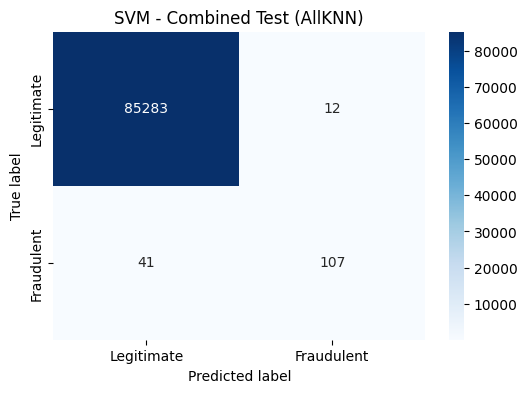

Evaluating Random Forest...
Random Forest Legit Accuracy: 0.99978
Random Forest Fraud Accuracy: 0.83784
Combined Confusion Matrix:


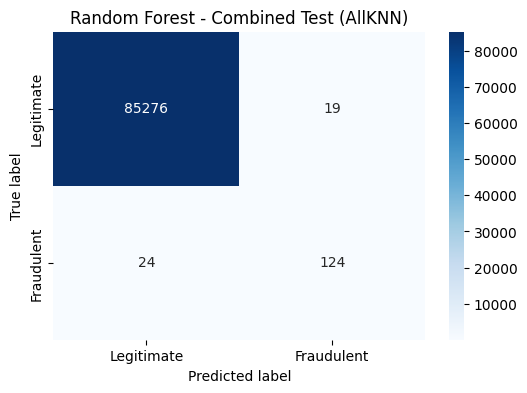

Evaluating Logistic Regression...
Logistic Regression Legit Accuracy: 0.99982
Logistic Regression Fraud Accuracy: 0.62162
Combined Confusion Matrix:


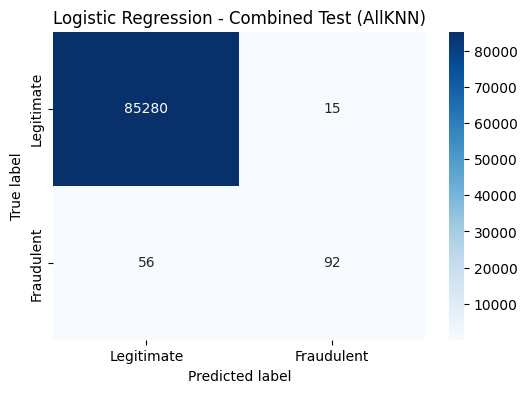

Evaluating AdaBoost...
AdaBoost Legit Accuracy: 0.99968
AdaBoost Fraud Accuracy: 0.64189
Combined Confusion Matrix:


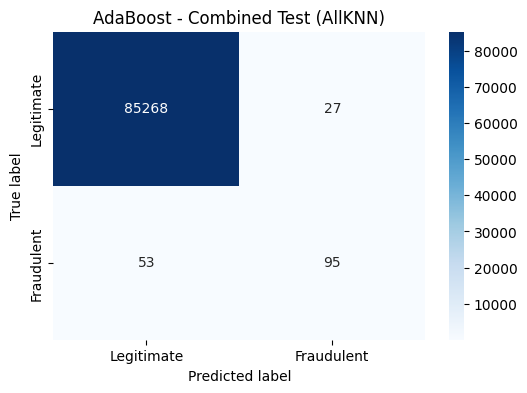

Evaluating GaussianNB...
GaussianNB Legit Accuracy: 0.97815
GaussianNB Fraud Accuracy: 0.84459
Combined Confusion Matrix:


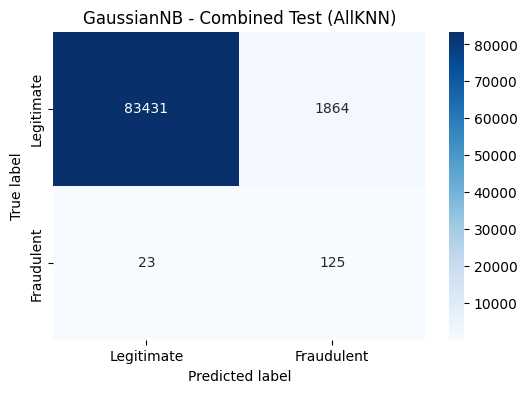

Evaluating KNN...
KNN Legit Accuracy: 0.99981
KNN Fraud Accuracy: 0.79054
Combined Confusion Matrix:


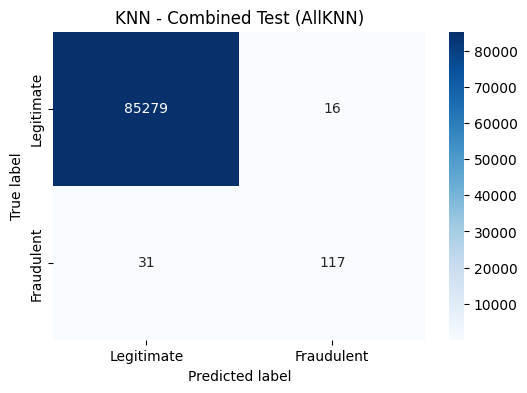

Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Legit Accuracy: 0.99984
XGBoost Fraud Accuracy: 0.83784
Combined Confusion Matrix:


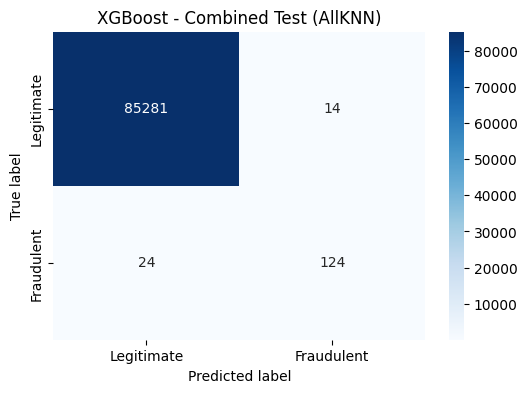

In [13]:
from imblearn.under_sampling import AllKNN

# Apply AllKNN undersampling
allknn = AllKNN(n_neighbors=3)
x_train_allknn, y_train_allknn = allknn.fit_resample(x_train, y_train)

results_allknn = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Use correctly resampled data from AllKNN
    results_allknn[model_name] = evaluate_model(
        model, x_train_allknn, y_train_allknn,
        x_legit_test, y_legit_test,
        x_fraud_test, y_fraud_test
    )

    print(f"{model_name} Legit Accuracy: {results_allknn[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_allknn[model_name]['accuracy_fraud']:.5f}")

    # Plot only the combined confusion matrix
    print("Combined Confusion Matrix:")
    plot_confusion_matrix(
        results_allknn[model_name]['confusion_matrix_combined'],
        title=f'{model_name} - Combined Test (AllKNN)'
    )


In [14]:
print('shape of x_train_rus', x_train_allknn.shape)
print('shape of y_train_rus', y_train_allknn.shape)

print(results_allknn)

shape of x_train_rus (199224, 29)
shape of y_train_rus (199224,)
{'Decision Tree': {'accuracy_legit': np.float64(0.9997537956503898), 'accuracy_fraud': np.float64(0.7905405405405406), 'confusion_matrix_combined': array([[85274,    21],
       [   31,   117]])}, 'SVM': {'accuracy_legit': np.float64(0.9998593118002228), 'accuracy_fraud': np.float64(0.722972972972973), 'confusion_matrix_combined': array([[85283,    12],
       [   41,   107]])}, 'Random Forest': {'accuracy_legit': np.float64(0.999777243683686), 'accuracy_fraud': np.float64(0.8378378378378378), 'confusion_matrix_combined': array([[85276,    19],
       [   24,   124]])}, 'Logistic Regression': {'accuracy_legit': np.float64(0.9998241397502784), 'accuracy_fraud': np.float64(0.6216216216216216), 'confusion_matrix_combined': array([[85280,    15],
       [   56,    92]])}, 'AdaBoost': {'accuracy_legit': np.float64(0.9996834515505012), 'accuracy_fraud': np.float64(0.6418918918918919), 'confusion_matrix_combined': array([[85268,

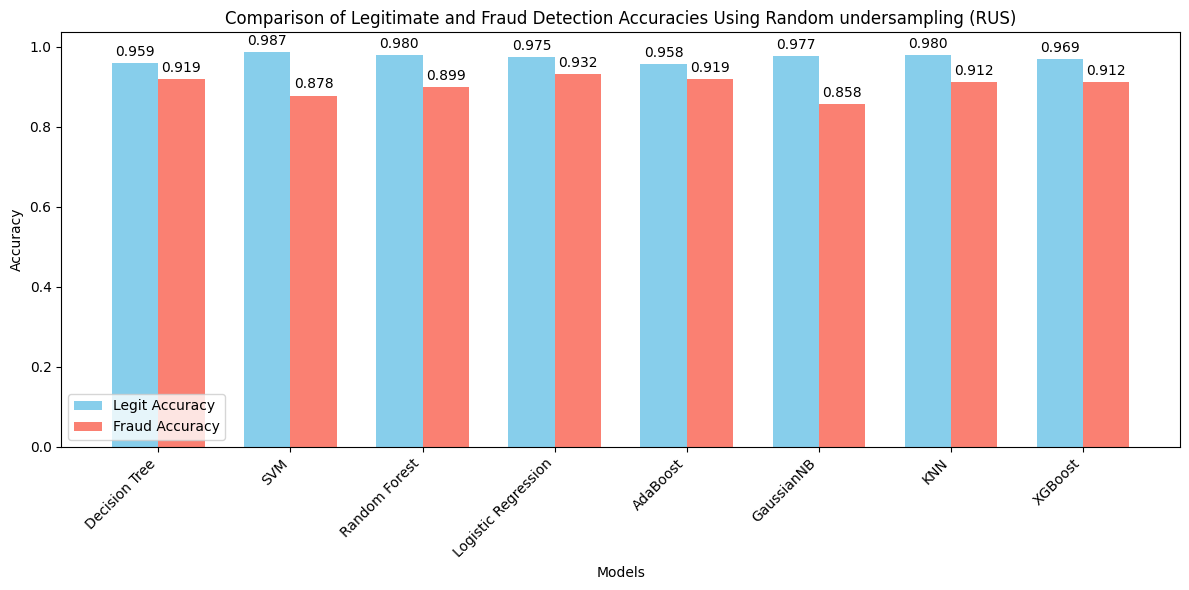

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_rus

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using Random undersampling (RUS)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


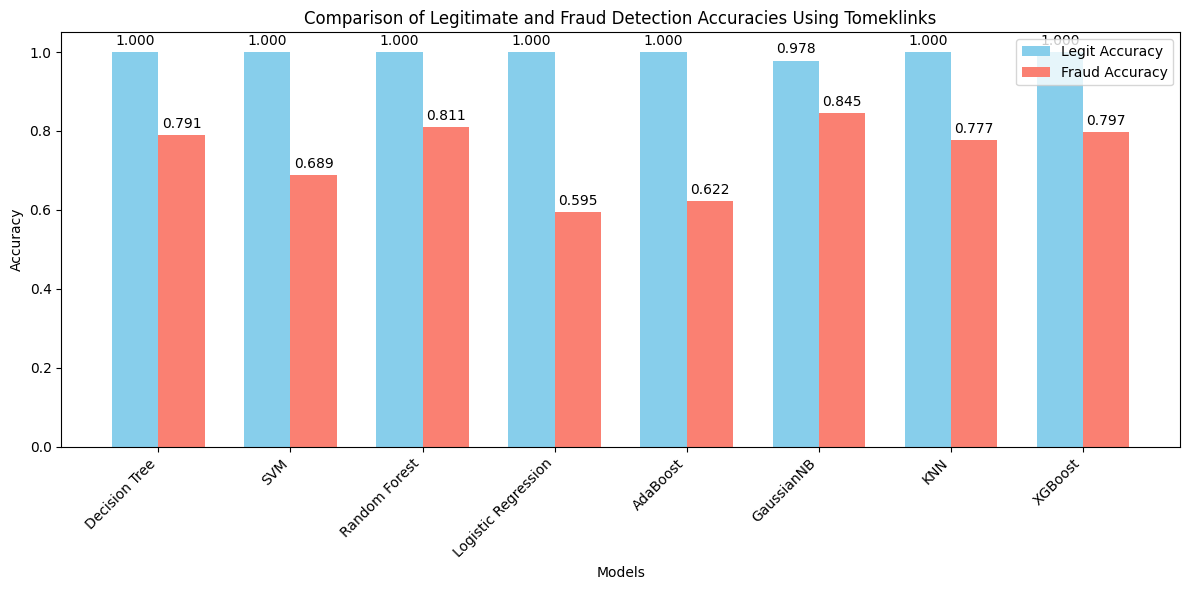

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_tl

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using Tomeklinks')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


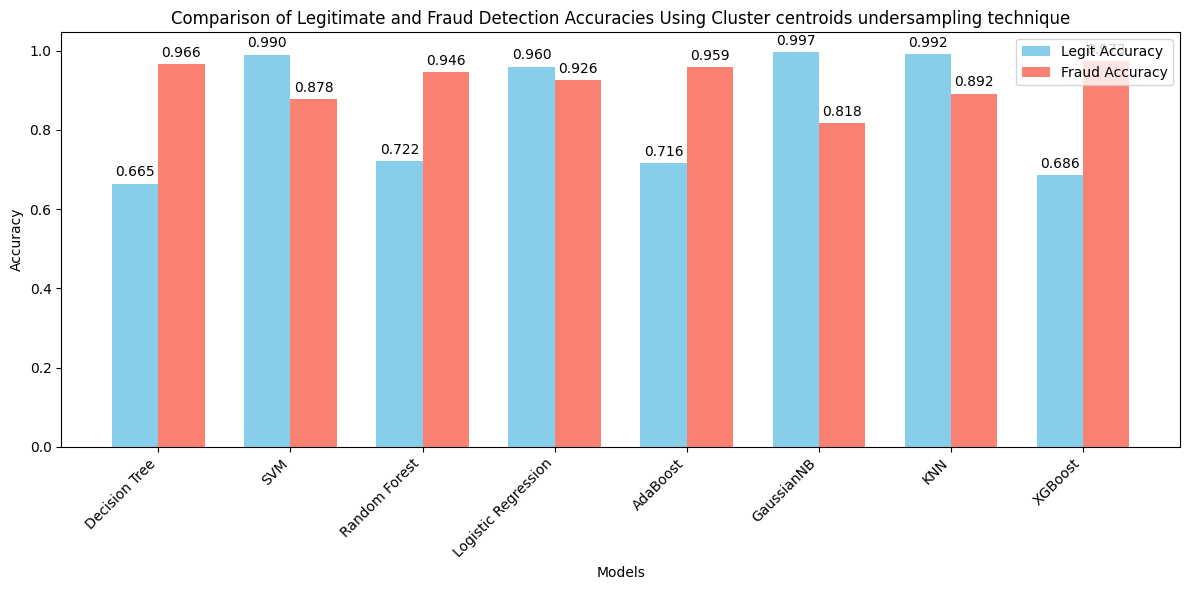

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_cc

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using Cluster centroids undersampling technique')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


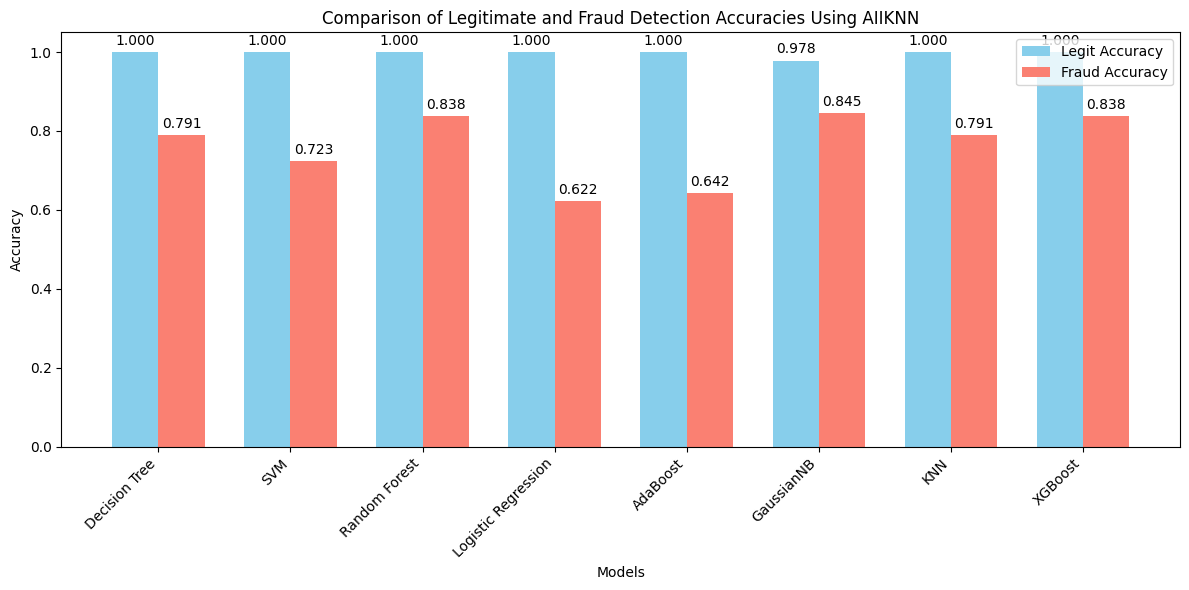

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_allknn

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using AIIKNN')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# Example data structure for different techniques (replace with actual results)
results = {
    'RUS': results_rus,
    'TomekLinks': results_tl,
    'ClusterCentroids': results_cc,
    'AllKNN': results_allknn
}

# Create a list to store the table data
table_data = []

for technique, models in results.items():
    row = {'Technique': technique}
    for model, acc in models.items():
        row[f'{model} (Legit)'] = f"{acc['accuracy_legit']:.5f}"
        row[f'{model} (Fraud)'] = f"{acc['accuracy_fraud']:.5f}"
    table_data.append(row)

# Convert to DataFrame
df_results = pd.DataFrame(table_data)

# Display the table
print(df_results.to_string(index=False))

# Optional: display table nicely in Jupyter Notebook
from IPython.display import display
display(df_results)


       Technique Decision Tree (Legit) Decision Tree (Fraud) SVM (Legit) SVM (Fraud) Random Forest (Legit) Random Forest (Fraud) Logistic Regression (Legit) Logistic Regression (Fraud) AdaBoost (Legit) AdaBoost (Fraud) GaussianNB (Legit) GaussianNB (Fraud) KNN (Legit) KNN (Fraud) XGBoost (Legit) XGBoost (Fraud)
             RUS               0.95895               0.91892     0.98720     0.87838               0.98025               0.89865                     0.97492                     0.93243          0.95764          0.91892            0.97707            0.85811     0.97994     0.91216         0.96863         0.91216
      TomekLinks               0.99985               0.79054     0.99991     0.68919               0.99988               0.81081                     0.99984                     0.59459          0.99962          0.62162            0.97822            0.84459     0.99985     0.77703         0.99991         0.79730
ClusterCentroids               0.66461               0.96622 

,Technique,Decision Tree (Legit),Decision Tree (Fraud),SVM (Legit),SVM (Fraud),Random Forest (Legit),Random Forest (Fraud),Logistic Regression (Legit),Logistic Regression (Fraud),AdaBoost (Legit),AdaBoost (Fraud),GaussianNB (Legit),GaussianNB (Fraud),KNN (Legit),KNN (Fraud),XGBoost (Legit),XGBoost (Fraud)
0,RUS,0.95895,0.91892,0.98720,0.87838,0.98025,0.89865,0.97492,0.93243,0.95764,0.91892,0.97707,0.85811,0.97994,0.91216,0.96863,0.91216
1,TomekLinks,0.99985,0.79054,0.99991,0.68919,0.99988,0.81081,0.99984,0.59459,0.99962,0.62162,0.97822,0.84459,0.99985,0.77703,0.99991,0.79730
2,ClusterCentroids,0.66461,0.96622,0.99042,0.87838,0.72165,0.94595,0.95994,0.92568,0.71613,0.95946,0.99679,0.81757,0.99204,0.89189,0.68617,0.97297
3,AllKNN,0.99975,0.79054,0.99986,0.72297,0.99978,0.83784,0.99982,0.62162,0.99968,0.64189,0.97815,0.84459,0.99981,0.79054,0.99984,0.83784
